<a href="https://colab.research.google.com/github/sohiniroych/AI_with_Sohini_Notebooks/blob/main/Resume_Screening_with_NLP_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code is used to generate resume screening using Natural Language Processing. 
This code is based on the the article in https://www.analyticsvidhya.com/blog/2021/06/resume-screening-with-natural-language-processing-in-python/

## The dataset used here is the publically available data from Kaggle. You can download the data using the below link.

 https://www.kaggle.com/gauravduttakiit/resume-dataset
 

## The various tasks at hand are as follows:
1. Exploratory Data Analysis
2. Data pre-processing
3. Data Modeling (with Training/Test Data)
4. Learining the top keywords across resumes.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Lecture_series/')
!ls

Clustered_data_cosmetics_tsne.csv
creditcard.csv
eCommerce_Demo_Lecture_3.ipynb
FE
logs
logs.log
logs_new
Machine_Learning_Engineer_Walmart_Labs_Inventory_SOLUTIONS.ipynb
ML_Lecture_Series_4_Anomaly_Detection.ipynb
ML_lecture_Series_CV_Transfer_learning.ipynb
Named_Entity_Recognition_BC5CDR_for_medical_data.ipynb
Resume_Screening_with_NLP_prototype.ipynb
tree.dot
tree.png
UpdatedResumeDataSet.csv
UT_Biomechanics
Walmart_bath_data_2022.csv
Walmart_bath_data_2022.gsheet


In [8]:
df = pd.read_csv('UpdatedResumeDataSet.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


#1. Exploratory Data Analysis (EDA)

In [9]:
category = df['Category'].value_counts().reset_index()
category

,index,Category
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


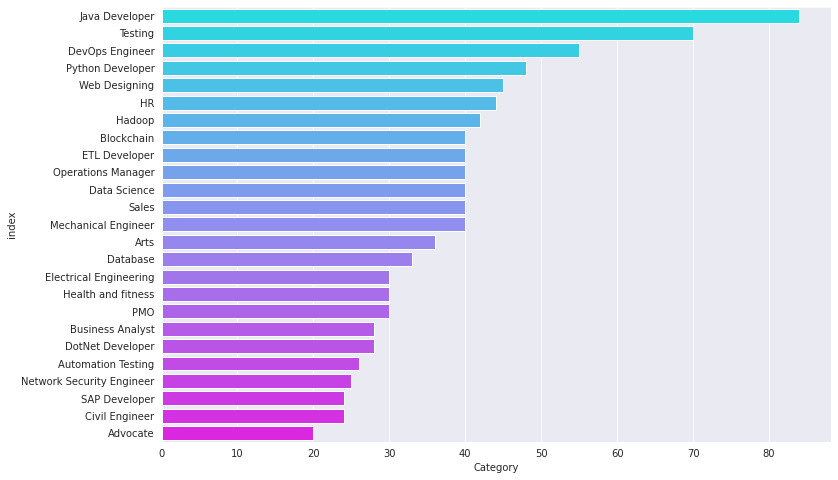

In [10]:
plt.figure(figsize=(12,8))
sns.barplot(x=category['Category'], y=category['index'], palette='cool')
plt.show()

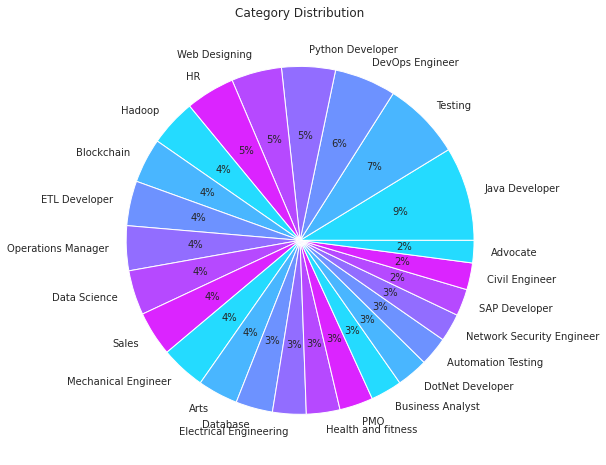

In [11]:
plt.figure(figsize=(12,8))
plt.pie(category['Category'], labels=category['index'],
        colors=sns.color_palette('cool'), autopct='%.0f%%')
plt.title('Category Distribution')
plt.show()

#2. Data Pre-processing:
1. Data Cleaning
2. Data Encoding

In [12]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [13]:
df['cleaned'] = df['Resume'].apply(lambda x:cleanResume(x))
df.head()

,Category,Resume,cleaned
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


In [14]:
#getting the entire resume text
corpus=" "
for i in range(0,len(df)):
    corpus= corpus+ df["cleaned"][i]

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
#Tokenizing the text
tokens = tokenizer.tokenize(corpus)
len(tokens)

411913

In [17]:
#now we shall make everything lowercase for uniformity
#to hold the new lower case words
words = []
# Looping through the tokens and make them lower case
for word in tokens:
    words.append(word.lower())
words[0:5]

['skills', 'programming', 'languages', 'python', 'pandas']

In [18]:
# Now encode the data
label = LabelEncoder()
df['new_Category'] = label.fit_transform(df['Category'])
df.head()

,Category,Resume,cleaned,new_Category
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...,6
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...,6


(array([ 82.,  68.,  97.,  83.,  70., 116., 124.,  95.,  72., 155.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

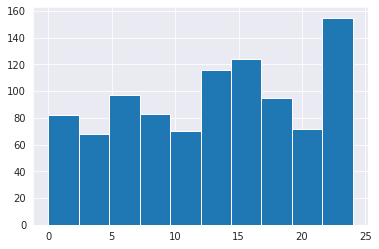

In [19]:
plt.hist(df['new_Category'])

In [20]:
# Vectorizing the cleaned columns
text = df['cleaned'].values
target = df['new_Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(text)
WordFeatures = word_vectorizer.transform(text)

In [21]:
WordFeatures.shape

(962, 1500)

# 3: Train Test Data and Modeling

In [22]:
# Separate train and test data
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, target, random_state=24, test_size=0.2)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((769, 1500), (193, 1500), (769,), (193,))

In [24]:
# Model Training
model = OneVsRestClassifier(KNeighborsClassifier())
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [25]:
# Prediction
y_pred = model.predict(X_test)

In [26]:
print(f'---------------------------------\n| Training Accuracy   :- {(model.score(X_train, y_train)*100).round(2)}% |')
print(f'---------------------------------\n| Validation Accuracy :- {(model.score(X_test, y_test)*100).round(2)}% |\n---------------------------------')

---------------------------------
| Training Accuracy   :- 98.96% |
---------------------------------
| Validation Accuracy :- 96.89% |
---------------------------------


In [27]:
print(metrics.classification_report(y_test, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00         7
          17       1.00    

#4. To learn the top keywords to analyze.

In [28]:
#Stop words are generally the most common words in a language.
#English stop words from nltk.
stopwords = nltk.corpus.stopwords.words('english')
words_new = []
#Now we need to remove the stop words from the words variable
#Appending to words_new all words that are in words but not in sw
for word in words:
    if word not in stopwords:
        words_new.append(word)

In [29]:
words_new[0:5]

['skills', 'programming', 'languages', 'python', 'pandas']

In [31]:
  import nltk
  nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [32]:
# Perform Lemmatization
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
wn = WordNetLemmatizer() 
lem_words=[]
for word in words_new:
    word=wn.lemmatize(word)
    lem_words.append(word)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
lem_words[0:5]

['skill', 'programming', 'language', 'python', 'panda']

In [34]:
same=0
diff=0
for i in range(0,1832):
    if(lem_words[i]==words_new[i]):
        same=same+1
    elif(lem_words[i]!=words_new[i]):
        diff=diff+1
print('Number of words Lemmatized=', diff)
print('Number of words not Lemmatized=', same)

Number of words Lemmatized= 294
Number of words not Lemmatized= 1538


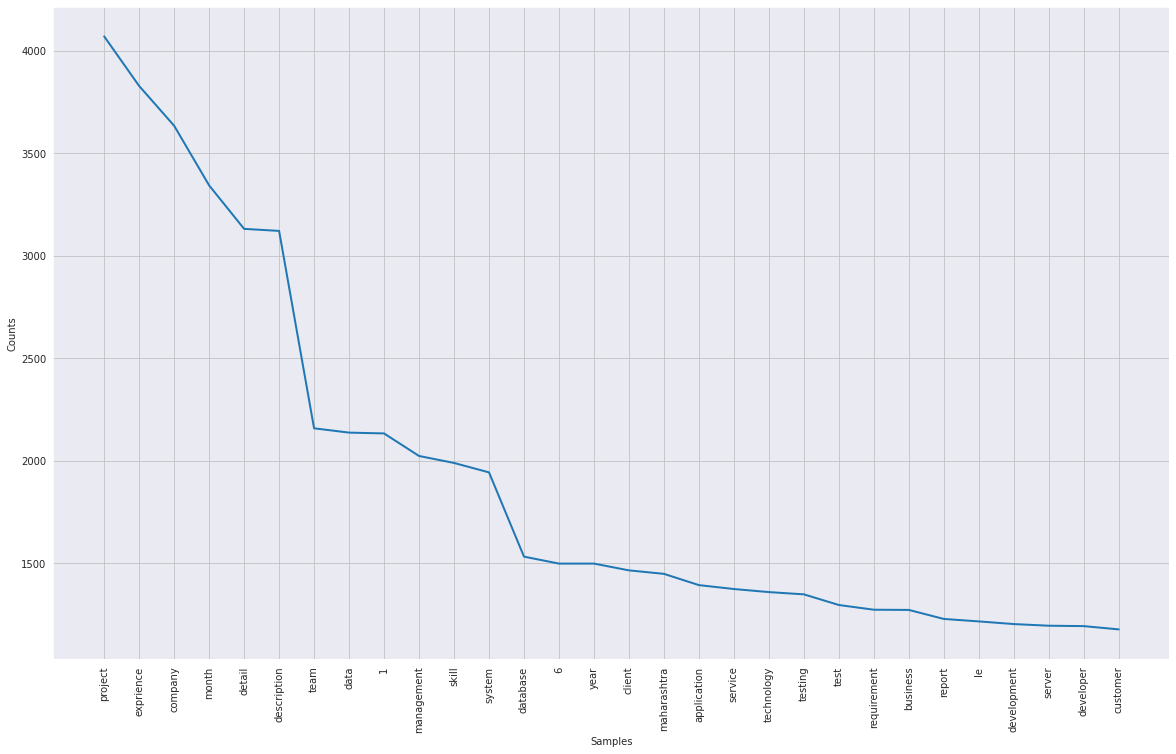

In [35]:
#The frequency distribution of the words
freq_dist = nltk.FreqDist(lem_words)
#Frequency Distribution Plot
plt.subplots(figsize=(20,12))
freq_dist.plot(30)

In [36]:
# Now we generate wordcloud
res=' '.join([i for i in lem_words if not i.isdigit()])

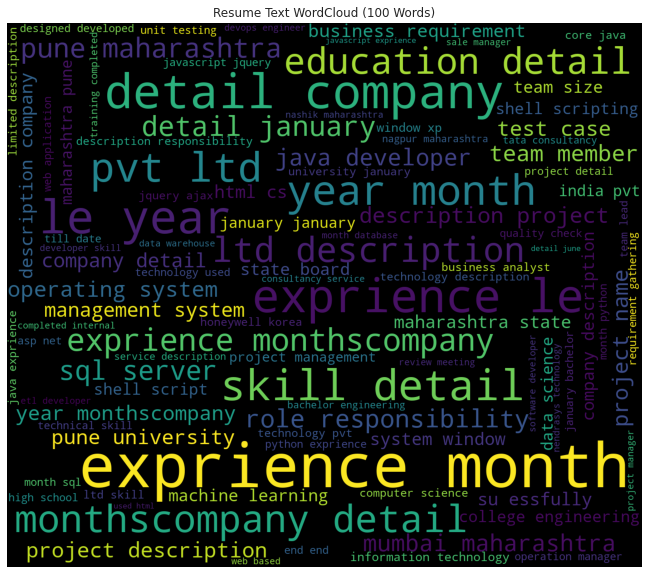

In [37]:
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=100,
                          width=1400,
                          height=1200
                         ).generate(res)
plt.imshow(wordcloud)
plt.title('Resume Text WordCloud (100 Words)')
plt.axis('off')
plt.show()

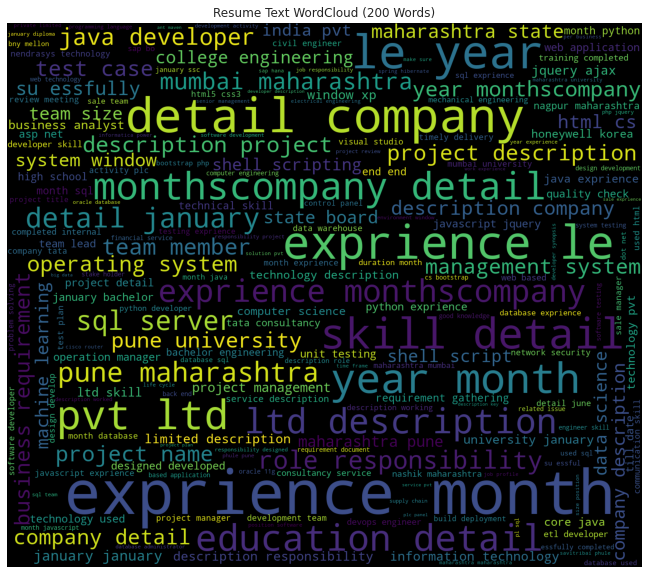

In [38]:
plt.subplots(figsize=(16,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=200,
                          width=1400,
                          height=1200
                         ).generate(res)
plt.imshow(wordcloud)
plt.title('Resume Text WordCloud (200 Words)')
plt.axis('off')
plt.show()